# Roget vs. LLM: Generative Models and Classical Semantic Ontology

This notebook provides a complete, reproducible framework for comparing the 1911 edition of Roget's Thesaurus against LLM-generated reconstructions. The Roget data is treated as ground truth; the LLM is asked to reproduce each Head entry from memory.

| Section | Description |
|---|---|
| **1. Imports** | All library imports |
| **2. Configuration** | Model, sample size, cache paths |
| **3. Functions** | Parser, caching, LLM queries, evaluation, ML |
| **4. Data Acquisition** | Parse Roget, sample n=30 Heads, query LLM |
| **5. Classical Evaluation** | TP/FP/FN metrics per field |
| **6. Semantic Similarity** | Sentence-embedding cosine similarity |
| **7. Hallucination Classifier** | Logistic regression hallucination detector |
| **8. Interpretation** | Summary of findings |

> **Caching**: All expensive operations are cached. Re-running any cell loads from `cache/` instead of re-executing. LLM responses are also saved incrementally to `cache/llm_responses_incremental.jsonl` after each query, so no progress is lost if the run is interrupted.

## 1. Imports

In [1]:
import os, re, json, time, pickle, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from functools import wraps
from matplotlib.colors import LinearSegmentedColormap
from openai import OpenAI
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, roc_auc_score, log_loss, matthews_corrcoef
)
from sentence_transformers import SentenceTransformer, util as st_util
pd.options.mode.chained_assignment = None

## 2. Configuration

| Parameter | Value | Notes |
|---|---|---|
| `SAMPLE_SIZE` | 30 | Heads sampled from Roget |
| `LLM_MODEL` | `gpt-4.1-mini` | OpenAI model |
| `RANDOM_SEED` | 42 | Reproducibility |
| `ST_MODEL_NAME` | `all-MiniLM-L6-v2` | Sentence transformer |

In [2]:
LLM_MODEL        = 'gpt-4.1-mini'
SAMPLE_SIZE      = 30
RANDOM_SEED      = 42
CACHE_DIR        = 'cache'
os.makedirs(CACHE_DIR, exist_ok=True)
ROGET_PARSED_CACHE  = f'{CACHE_DIR}/roget_parsed.pkl'
LLM_CACHE           = f'{CACHE_DIR}/llm_responses.pkl'
LLM_JSONL_CACHE     = f'{CACHE_DIR}/llm_responses_incremental.jsonl'
SEMANTIC_CACHE      = f'{CACHE_DIR}/semantic_similarity.pkl'
CLASSIFIER_CACHE    = f'{CACHE_DIR}/hallucination_classifier.pkl'
ST_MODEL_NAME       = 'all-MiniLM-L6-v2'
EVAL_COLS           = ['noun_list', 'verb_list', 'adjective_list',
                        'adverb_list', 'cross_references']
print(f'Config: n={SAMPLE_SIZE}, model={LLM_MODEL}, seed={RANDOM_SEED}')

Config: n=30, model=gpt-4.1-mini, seed=42


## 3. Functions

- **3.1 Roget Parser** — parse the 1911 plain-text thesaurus into structured dicts
- **3.2 Caching utilities** — decorator-based disk caching
- **3.3 LLM query functions** — query OpenAI with incremental JSONL caching
- **3.4 Evaluation functions** — TP/FP/FN/TN for set-valued fields
- **3.5 ML functions** — semantic similarity and hallucination classifier

### 3.1 Roget Parser

In [3]:
def parse_roget(file_path):
    """
    Parse the 1911 Roget's Thesaurus (Project Gutenberg #10681).
    Returns clean Head dicts with 8 fields. Sub-entries and malformed
    head names are excluded.
    """
    with open(file_path, 'r', encoding='utf-8-sig') as f:
        lines = f.readlines()
    roget_data, current_class, current_section, current_head = [], '', '', None
    for raw in lines:
        line = raw.strip()
        if not line: continue
        if '*** START OF' in line or '*** END OF' in line: continue
        m = re.match(r'^CLASS (I{1,3}|IV|V|VI)\b(.*)$', line)
        if m: current_class = f'CLASS {m.group(1)}{m.group(2).strip()}'; continue
        m = re.match(r'^SECTION ([IVXLC]+|[\dA-Za-z]+)\.\s*(.*)$', line)
        if m: current_section = line; continue
        # Exclude sub-entries like '480.1' by requiring a space after the dot
        m = re.match(r'^(\d+)\.\s+(.+)$', line)
        if m and not re.match(r'^\d+\.\d', line):
            if current_head: roget_data.append(current_head)
            raw_name = m.group(2).strip()
            em_split = re.split(r'\s*[\u2014\u2013]\s*', raw_name, maxsplit=1)
            if len(em_split) == 2:
                head_name = re.sub(r'^\[.*?\]\s*', '', em_split[0]).strip()
                inline_content = em_split[1]
            else:
                head_name, inline_content = raw_name, ''
            current_head = {'class': current_class, 'section': current_section,
                            'head_number': int(m.group(1)), 'head_name': head_name,
                            '_content': inline_content}
        elif current_head:
            current_head['_content'] += ' ' + line
    if current_head: roget_data.append(current_head)

    pos_patterns = {
        'noun_list':      r'N\.\s(.*?)(?=\s*(?:V\.|Adj\.|Adv\.|Phr\.|\Z))',
        'verb_list':      r'V\.\s(.*?)(?=\s*(?:N\.|Adj\.|Adv\.|Phr\.|\Z))',
        'adjective_list': r'Adj\.\s(.*?)(?=\s*(?:N\.|V\.|Adv\.|Phr\.|\Z))',
        'adverb_list':    r'Adv\.\s(.*?)(?=\s*(?:N\.|V\.|Adj\.|Phr\.|\Z))',
    }
    for head in roget_data:
        c = head.pop('_content')
        for key, pat in pos_patterns.items():
            matches = re.findall(pat, c, re.DOTALL)
            head[key] = [item.strip().replace('\n', ' ')
                         for sub in matches for item in sub.split(';') if item.strip()]
        refs = re.findall(r'&c\s(\d+)', c)
        head['cross_references'] = [int(r) for r in refs]
    head_map = {h['head_number']: h['head_name'] for h in roget_data}
    for head in roget_data:
        head['cross_references'] = [head_map.get(r, f'UNKNOWN_REF_{r}')
                                     for r in head['cross_references']]
    def _is_clean(h):
        n = h['head_name']
        if not n or len(n) > 60 or ';' in n or n[0].isdigit(): return False
        return any([h['noun_list'], h['verb_list'], h['adjective_list'], h['adverb_list']])
    return [h for h in roget_data if _is_clean(h)]

### 3.2 Caching Utilities

In [4]:
def cache_object(cache_path):
    """Decorator: cache any Python object to a .pkl file."""
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            if os.path.exists(cache_path):
                print(f'[CACHE] Loading from {cache_path}')
                with open(cache_path, 'rb') as f: return pickle.load(f)
            result = func(*args, **kwargs)
            with open(cache_path, 'wb') as f: pickle.dump(result, f)
            return result
        return wrapper
    return decorator

### 3.3 LLM Query Functions

In [5]:
SYSTEM_PROMPT = (
    'You are an expert in historical English lexicography and the 1911 edition of '
    "Roget's Thesaurus. Given a Head name, reconstruct the full thesaurus entry. "
    'Return a JSON object with exactly these keys: '
    'class, section, head_name, noun_list, verb_list, '
    'adjective_list, adverb_list, cross_references. '
    'Keep each list concise (10-20 items max) to avoid truncation.'
)

def _get_client():
    """Return an OpenAI client using the OPENAI_API_KEY environment variable."""
    return OpenAI()

def query_llm_for_head(head_name, client, model, max_retries=4):
    """Query with exponential backoff; returns dict or None."""
    for attempt in range(max_retries):
        try:
            resp = client.chat.completions.create(
                model=model,
                messages=[{'role': 'system', 'content': SYSTEM_PROMPT},
                           {'role': 'user', 'content': f'Head name: {head_name}'}],
                temperature=0, max_tokens=1024,
                response_format={'type': 'json_object'},
            )
            return json.loads(resp.choices[0].message.content)
        except Exception as exc:
            wait = 2 ** attempt
            print(f'  [WARN] Attempt {attempt+1} failed for "{head_name}": {exc}')
            if attempt < max_retries - 1: time.sleep(wait)
    return None

def get_all_llm_reconstructions(sample_heads, client):
    """
    Query the LLM for each Head. Saves each response immediately to an
    incremental JSONL file, then writes the final pkl cache when done.
    """
    if os.path.exists(LLM_CACHE):
        print(f'[CACHE] Loading from {LLM_CACHE}')
        with open(LLM_CACHE, 'rb') as f: return pickle.load(f)
    done = {}
    if os.path.exists(LLM_JSONL_CACHE):
        with open(LLM_JSONL_CACHE, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if line:
                    rec = json.loads(line)
                    done[rec['_source_head_name']] = rec
        print(f'[RESUME] {len(done)} entries already cached in JSONL.')
    results = []
    with open(LLM_JSONL_CACHE, 'a', encoding='utf-8') as jf:
        for i, head in enumerate(sample_heads):
            name = head['head_name']
            if name in done:
                print(f'  [{i+1}/{len(sample_heads)}] CACHED: {name}')
                results.append(done[name]); continue
            print(f'  [{i+1}/{len(sample_heads)}] Querying: {name}')
            rec = query_llm_for_head(name, client, LLM_MODEL)
            if rec:
                rec['_source_head_name'] = name
                jf.write(json.dumps(rec, ensure_ascii=False) + '\n')
                jf.flush()
            results.append(rec)
            time.sleep(0.5)
    with open(LLM_CACHE, 'wb') as f: pickle.dump(results, f)
    good = sum(1 for r in results if r)
    print(f'Done. {good}/{len(sample_heads)} successful.')
    return results

### 3.4 Evaluation Functions

In [6]:
def _normalise_list(lst):
    if not isinstance(lst, list): return set()
    return {str(x).lower().strip() for x in lst if x}

def _classify_set(roget_val, llm_val):
    w = _normalise_list(roget_val); l = _normalise_list(llm_val)
    return {'TP': len(w & l), 'FP': len(l - w), 'FN': len(w - l), 'TN': 0}

def evaluate(roget_df, llm_df, verbose=True):
    r = roget_df.copy(); l = llm_df.copy()
    r['_key'] = r['head_name'].str.lower().str.strip()
    l['_key'] = l['head_name'].str.lower().str.strip()
    merged = r.merge(l, on='_key', how='inner', suffixes=('_roget', '_llm'))
    n = len(merged)
    if verbose: print(f'Roget sample: {len(r)} | LLM: {len(l)} | Matched: {n}')
    summary_rows = []
    for col in EVAL_COLS:
        rc = f'{col}_roget' if f'{col}_roget' in merged.columns else col
        lc = f'{col}_llm'   if f'{col}_llm'   in merged.columns else col
        totals = {'TP': 0, 'FP': 0, 'FN': 0, 'TN': 0}
        for _, row in merged.iterrows():
            for k, v in _classify_set(row.get(rc, []), row.get(lc, [])).items():
                totals[k] += v
        tp, fp, fn, tn = totals['TP'], totals['FP'], totals['FN'], totals['TN']
        P  = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        R  = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        F1 = 2*P*R / (P+R) if (P+R) > 0 else 0.0
        Ac = (tp+tn) / (tp+tn+fp+fn) if (tp+tn+fp+fn) > 0 else 0.0
        summary_rows.append({'column': col, 'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn,
            'Precision': round(P,3), 'Recall': round(R,3),
            'F1': round(F1,3), 'Accuracy': round(Ac,3)})
    summary = pd.DataFrame(summary_rows).set_index('column')

    fig = plt.figure(figsize=(18, 14))
    fig.suptitle(f"LLM vs Roget's Thesaurus (n={n})",
                 fontsize=14, fontweight='bold', y=0.98)
    gs = gridspec.GridSpec(2, 2, figure=fig, hspace=0.45, wspace=0.35)
    cols_list = list(summary.index); x = np.arange(len(cols_list)); w = 0.55
    ax1 = fig.add_subplot(gs[0, 0])
    tp_v, fp_v, fn_v = summary['TP'].values, summary['FP'].values, summary['FN'].values
    ax1.bar(x, tp_v, w, label='TP', color='#2ecc71')
    ax1.bar(x, fp_v, w, bottom=tp_v, label='FP', color='#e74c3c')
    ax1.bar(x, fn_v, w, bottom=tp_v+fp_v, label='FN', color='#e67e22')
    ax1.set_xticks(x); ax1.set_xticklabels(cols_list, rotation=25, ha='right', fontsize=9)
    ax1.set_title('TP / FP / FN Counts per Field'); ax1.set_ylabel('Count')
    ax1.legend(loc='upper right', fontsize=8)
    ax2 = fig.add_subplot(gs[0, 1])
    metrics = ['Precision', 'Recall', 'F1', 'Accuracy']
    mcolors = ['#9b59b6', '#1abc9c', '#f39c12', '#2980b9']
    bw = 0.18
    offs = np.linspace(-(len(metrics)-1)/2, (len(metrics)-1)/2, len(metrics)) * bw
    for j, (m, c) in enumerate(zip(metrics, mcolors)):
        ax2.bar(x+offs[j], summary[m].values, bw, label=m, color=c, alpha=0.85)
    ax2.set_xticks(x); ax2.set_xticklabels(cols_list, rotation=25, ha='right', fontsize=9)
    ax2.set_ylim(0, 1.15); ax2.set_title('Precision / Recall / F1 / Accuracy')
    ax2.axhline(1.0, color='grey', linewidth=0.7, linestyle='--'); ax2.legend(fontsize=8)
    ax3 = fig.add_subplot(gs[1, 0])
    heat_d = summary[metrics].values.astype(float)
    cmap = LinearSegmentedColormap.from_list('rg', ['#e74c3c', '#f39c12', '#2ecc71'])
    im = ax3.imshow(heat_d.T, aspect='auto', cmap=cmap, vmin=0, vmax=1)
    ax3.set_xticks(range(len(cols_list)))
    ax3.set_xticklabels(cols_list, rotation=25, ha='right', fontsize=9)
    ax3.set_yticks(range(len(metrics))); ax3.set_yticklabels(metrics, fontsize=8)
    ax3.set_title('Metric Heatmap')
    for i in range(len(metrics)):
        for j in range(len(cols_list)):
            ax3.text(j, i, f'{heat_d[j,i]:.2f}', ha='center', va='center',
                     fontsize=7.5, color='black' if heat_d[j,i] > 0.4 else 'white')
    plt.colorbar(im, ax=ax3, fraction=0.03, pad=0.04)
    ax4 = fig.add_subplot(gs[1, 1])
    f1_vals = summary['F1'].values
    bar_colors = ['#2ecc71' if v>=0.7 else '#f39c12' if v>=0.4 else '#e74c3c' for v in f1_vals]
    ax4.bar(x, f1_vals, color=bar_colors)
    ax4.set_xticks(x); ax4.set_xticklabels(cols_list, rotation=25, ha='right', fontsize=9)
    ax4.set_ylim(0, 1.1); ax4.set_title('F1 Score per Field'); ax4.set_ylabel('F1')
    ax4.axhline(0.7, color='green',  linewidth=0.8, linestyle='--', label='0.7')
    ax4.axhline(0.4, color='orange', linewidth=0.8, linestyle='--', label='0.4')
    ax4.legend(fontsize=8)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    return summary, fig

### 3.5 ML Functions

In [7]:
def score_semantic_similarity(roget_df, llm_df, verbose=True):
    if os.path.exists(SEMANTIC_CACHE):
        print(f'[CACHE] Loading from {SEMANTIC_CACHE}')
        return pd.read_pickle(SEMANTIC_CACHE)
    if verbose: print(f'Loading sentence-transformer: {ST_MODEL_NAME}...')
    model = SentenceTransformer(ST_MODEL_NAME)
    r = roget_df.copy(); l = llm_df.copy()
    r['_key'] = r['head_name'].str.lower().str.strip()
    l['_key'] = l['head_name'].str.lower().str.strip()
    merged = r.merge(l, on='_key', how='inner', suffixes=('_roget', '_llm'))
    if verbose: print(f'Scoring {len(merged)} Heads...')
    results = []
    for _, row in merged.iterrows():
        hn = row.get('head_name_roget', row.get('head_name', ''))
        scores = {'head_name': hn}
        for col in EVAL_COLS:
            rc = f'{col}_roget' if f'{col}_roget' in row.index else col
            lc = f'{col}_llm'   if f'{col}_llm'   in row.index else col
            rv = [str(x) for x in (row.get(rc) or []) if x]
            lv = [str(x) for x in (row.get(lc) or []) if x]
            if not rv and not lv: scores[col] = 1.0
            elif not rv or not lv: scores[col] = 0.0
            else:
                e1 = model.encode(rv, convert_to_tensor=True)
                e2 = model.encode(lv, convert_to_tensor=True)
                sim = st_util.cos_sim(e1, e2)
                scores[col] = float(sim.max(dim=1).values.mean())
        results.append(scores)
    df = pd.DataFrame(results)
    df.to_pickle(SEMANTIC_CACHE)
    return df

def train_hallucination_classifier(roget_df, llm_df, semantic_df, verbose=True):
    """
    Logistic regression to predict hallucinated fields.
    Label: LLM produced a non-empty list for a field empty in Roget AND sim < 0.5.
    Reports: F1, Recall, Precision, Accuracy, ROC-AUC, Log-Loss, MCC.
    """
    if os.path.exists(CLASSIFIER_CACHE):
        print(f'[CACHE] Loading from {CLASSIFIER_CACHE}')
        with open(CLASSIFIER_CACHE, 'rb') as f: return pickle.load(f)
    r = roget_df.copy(); l = llm_df.copy()
    r['_key'] = r['head_name'].str.lower().str.strip()
    l['_key'] = l['head_name'].str.lower().str.strip()
    merged = r.merge(l, on='_key', how='inner', suffixes=('_roget', '_llm'))
    s = semantic_df.copy()
    s['_key'] = s['head_name'].str.lower().str.strip()
    feature_rows = []
    for _, row in merged.iterrows():
        key = row['_key']; sem_row = s[s['_key'] == key]
        for col in EVAL_COLS:
            rc = f'{col}_roget' if f'{col}_roget' in row.index else col
            lc = f'{col}_llm'   if f'{col}_llm'   in row.index else col
            rv = row.get(rc) or []; lv = row.get(lc) or []
            sim = float(sem_row[col].values[0]) if (not sem_row.empty and col in sem_row.columns) else 0.0
            feature_rows.append({'head_name': key, 'column': col,
                'semantic_similarity': sim, 'roget_list_exists': int(bool(rv)),
                'llm_list_length': len(lv),
                'is_hallucination': int(bool(lv) and not bool(rv) and sim < 0.5)})
    feat_df = pd.DataFrame(feature_rows)
    X = feat_df[['semantic_similarity', 'roget_list_exists', 'llm_list_length']]
    y = feat_df['is_hallucination']
    if len(y.unique()) < 2:
        print('[WARN] Only one class present; skipping classifier training.')
        feat_df['hallucination_probability'] = 0.0
        return None, feat_df
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)
    clf = LogisticRegression(class_weight='balanced', max_iter=500)
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_te); y_prob = clf.predict_proba(X_te)[:, 1]
    if verbose:
        print('--- Hallucination Classifier Report ---')
        print(classification_report(y_te, y_pred, target_names=['genuine', 'hallucinated']))
        auc = roc_auc_score(y_te, y_prob)
        ll  = log_loss(y_te, y_prob)
        mcc = matthews_corrcoef(y_te, y_pred)
        print(f'ROC-AUC: {auc:.3f}  |  Log-Loss: {ll:.3f}  |  MCC: {mcc:.3f}')
    feat_df['hallucination_probability'] = clf.predict_proba(X)[:, 1]
    result = (clf, feat_df)
    with open(CLASSIFIER_CACHE, 'wb') as f: pickle.dump(result, f)
    return result

## 4. Data Acquisition

Parse the full 1911 Roget's Thesaurus, sample n=30 clean Heads, and query the LLM for all 8 fields per Head. All results are cached.

In [8]:
@cache_object(ROGET_PARSED_CACHE)
def get_roget_data():
    return parse_roget('roget_thesaurus_1911.txt')

roget_data = get_roget_data()
roget_df   = pd.DataFrame(roget_data)
print(f'Parsed {len(roget_df)} clean Heads from Roget\'s Thesaurus.')
roget_df.head(3)

Parsed 997 clean Heads from Roget's Thesaurus.


,class,section,head_number,head_name,noun_list,verb_list,adjective_list,adverb_list,cross_references
0,CLASS I,SECTION I.,1,Existence,"[existence, being, entity, ens [Lat.], esse [L...","[exist, be, have being &c n., subsist, live, b...","[existing &c v., existent, under the sun, in e...","[actually &c adj., in fact, in point of fact, ...","[Truth, Synchronism, Imagination, Production, ..."
1,CLASS I,SECTION I.,2,Inexistence,"[inexistence†, nonexistence, nonsubsistence, n...","[not exist &c 1, have no existence &c 1, be nu...","[inexistent†, nonexistent &c 1, negative, blan...","[negatively, virtually &c adj..]","[Absence, ACTS OF RELIGION, SUPERHUMAN BEINGS ..."
2,CLASS I,SECTION I.,3,Substantiality,"[substantiality, hypostasis, person, being, th...",[],"[substantive, substantial, hypostatic, persona...","[substantially &c adj., bodily, essentially.]","[Materiality, World]"


In [9]:
random.seed(RANDOM_SEED)
sample_heads = random.sample(roget_data, SAMPLE_SIZE)
sample_df    = pd.DataFrame(sample_heads)
print(f'Sampled {len(sample_df)} Heads.')
sample_df[['head_number', 'head_name', 'class', 'section']].head(10)

Sampled 30 Heads.


,head_number,head_name,class,section
0,656,Salubrity,CLASS V,SECTION II.
1,114,Chronometry,CLASS I,SECTION VI.
2,26,Degree,CLASS I,SECTION III.
3,761,Prohibition,CLASS V,SECTION II.
4,281,Sequence,CLASS II,SECTION IV.
5,250,Convexity,CLASS II,SECTION III.
6,228,Interposition,CLASS II,SECTION II.
7,142,Cessation,CLASS I,SECTION VII.
8,756,Abrogation,CLASS V,SECTION I.
9,104,Repetition,CLASS I,SECTION V.


In [10]:
# The client is only created if cache/llm_responses.pkl does not exist.
# If you have the pre-populated cache, no API key is needed.
client  = _get_client() if not os.path.exists(LLM_CACHE) else None
llm_raw = get_all_llm_reconstructions(sample_heads, client)
llm_df  = pd.DataFrame([r for r in llm_raw if r is not None])
print(f'LLM reconstructions: {len(llm_df)} / {SAMPLE_SIZE} succeeded.')
llm_df.head(3)

[CACHE] Loading from cache/llm_responses.pkl
LLM reconstructions: 30 / 30 succeeded.


,class,section,head_name,noun_list,verb_list,adjective_list,adverb_list,cross_references,_source_head_name
0,3. Intellect,III. Health and Sickness,Salubrity,"[health, soundness, fitness, well-being, whole...","[to heal, to restore, to recuperate, to recover]","[healthy, salubrious, wholesome, sound, vigoro...","[healthily, salubriously, wholesomely]","[Head 278. Disease, Head 279. Medicaments]",Salubrity
1,6,II,Chronometry,"[time, chronology, chronometry, chronograph, c...","[to time, to measure time, to chronograph, to ...","[chronometric, chronological, timely, temporal...","[timely, punctually, periodically, regularly, ...","[705. Clockwork, 707. Measurement, 709. Freque...",Chronometry
2,I,5,Degree,"[degree, extent, amount, measure, quantity, sc...","[to measure, to gauge, to rate, to estimate, t...","[degree, measured, relative, proportionate, mo...","[altogether, entirely, fully, wholly, in part,...","[Quantity, Measure, Extent, Relation]",Degree


## 5. Classical Evaluation

Each field is treated as a **set of strings** (lower-cased, stripped). Aggregated across all matched Heads:

| Metric | Formula |
|---|---|
| **TP** | Items in both Roget and LLM |
| **FP** | Items in LLM only (hallucinations / additions) |
| **FN** | Items in Roget only (omissions) |
| **Precision** | TP / (TP + FP) |
| **Recall** | TP / (TP + FN) |
| **F1** | 2 × P × R / (P + R) |

Roget sample: 30 | LLM: 30 | Matched: 30


/var/folders/p0/k2jczrpj3mzbk9jp5y57hctr0000gn/T/ipykernel_48918/2786854062.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


                  TP   FP   FN  TN  Precision  Recall     F1  Accuracy
column                                                                
noun_list          9  366  451   0      0.024   0.020  0.022     0.011
verb_list          5  255  244   0      0.019   0.020  0.020     0.010
adjective_list     5  281  258   0      0.017   0.019  0.018     0.009
adverb_list        0  154   82   0      0.000   0.000  0.000     0.000
cross_references   4  100   72   0      0.038   0.053  0.044     0.023


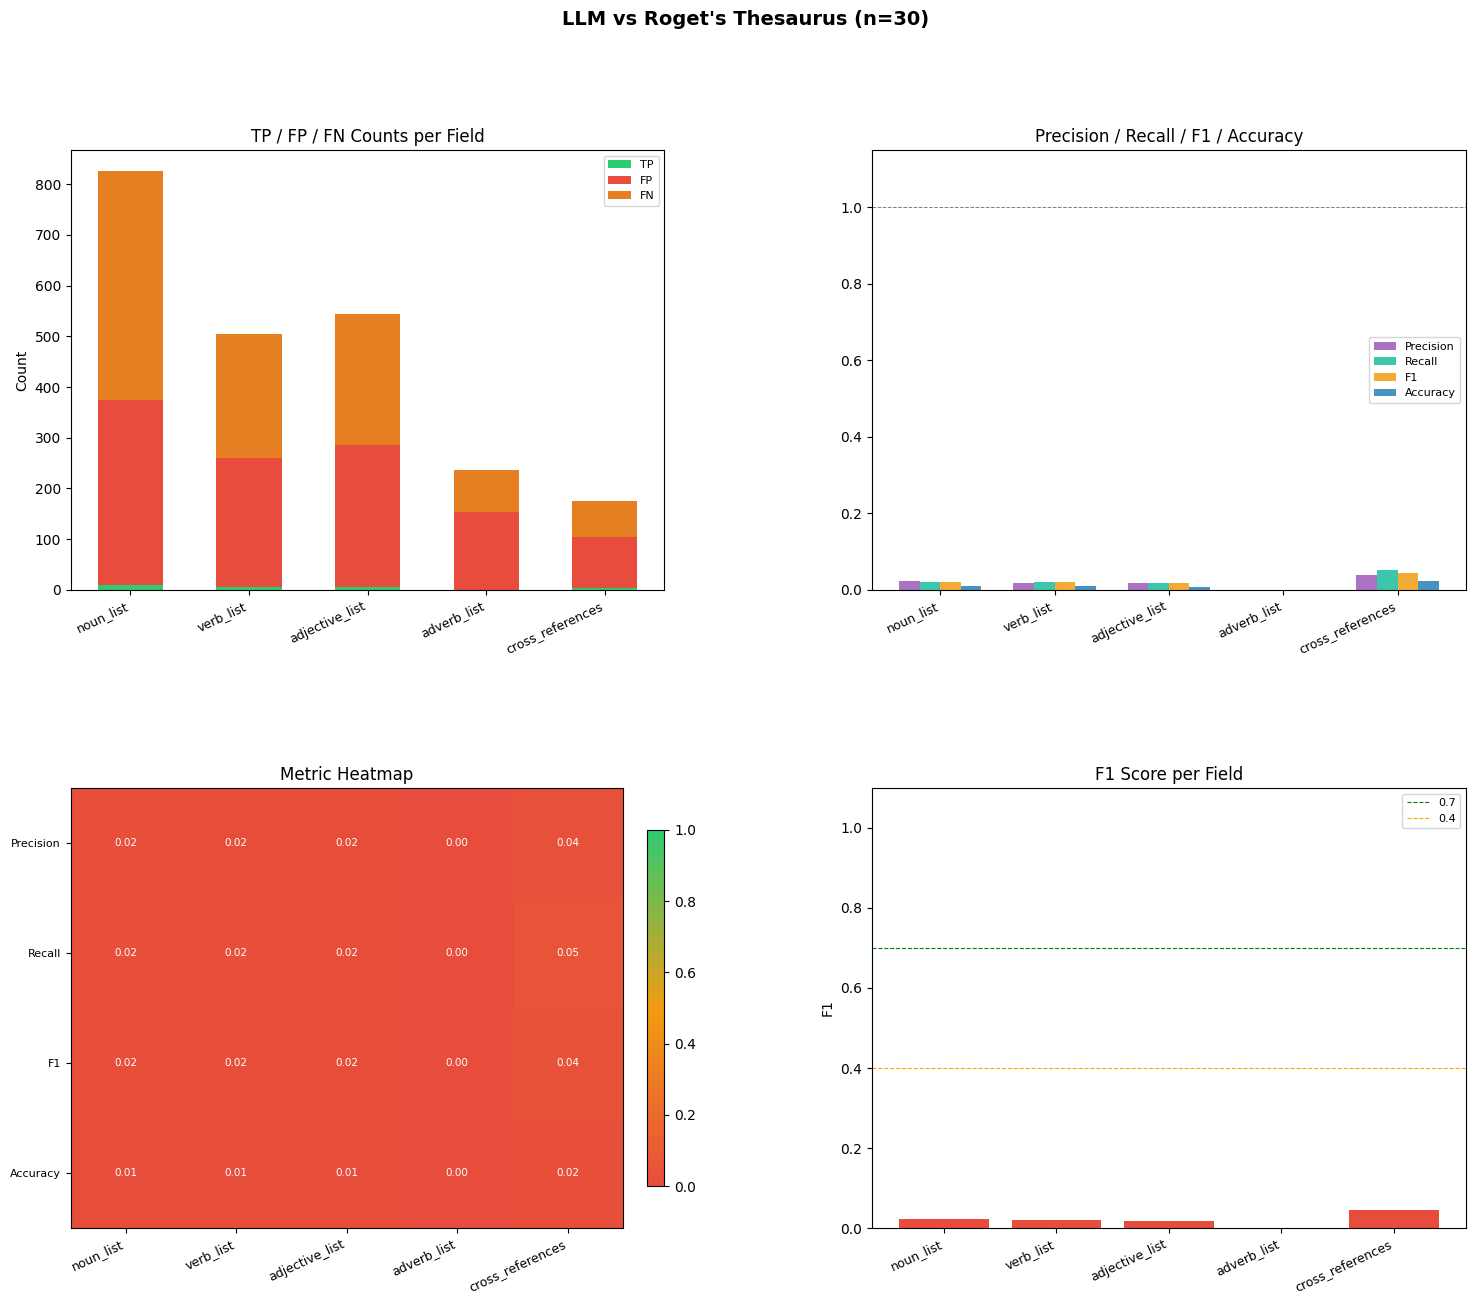

In [11]:
summary_df, eval_fig = evaluate(sample_df, llm_df)
print(summary_df.to_string())
eval_fig.savefig('eval_classical.png', dpi=150, bbox_inches='tight')
plt.show()

In [12]:
summary_df.style.background_gradient(cmap='RdYlGn',
    subset=['Precision', 'Recall', 'F1', 'Accuracy'])

,TP,FP,FN,TN,Precision,Recall,F1,Accuracy
column,,,,,,,,
noun_list,9,366,451,0,0.024000,0.020000,0.022000,0.011000
verb_list,5,255,244,0,0.019000,0.020000,0.020000,0.010000
adjective_list,5,281,258,0,0.017000,0.019000,0.018000,0.009000
adverb_list,0,154,82,0,0.000000,0.000000,0.000000,0.000000
cross_references,4,100,72,0,0.038000,0.053000,0.044000,0.023000


## 6. Semantic Similarity Analysis

Using the `all-MiniLM-L6-v2` sentence-transformer, each list of words/phrases is encoded into a dense vector. The mean maximum cosine similarity between Roget and LLM embeddings is computed per field. Score 1.0 = perfect semantic overlap; 0.0 = none.

In [13]:
semantic_df = score_semantic_similarity(sample_df, llm_df)
print(semantic_df.describe().round(3))
semantic_df.head()

[CACHE] Loading from cache/semantic_similarity.pkl
       noun_list  verb_list  adjective_list  adverb_list  cross_references
count     19.000     19.000          19.000       19.000            19.000
mean       0.346      0.285           0.290        0.075             0.324
std        0.189      0.190           0.219        0.138             0.302
min        0.000      0.000           0.000        0.000             0.000
25%        0.275      0.162           0.117        0.000             0.000
50%        0.306      0.340           0.319        0.000             0.336
75%        0.383      0.356           0.400        0.055             0.528
max        1.000      0.627           0.718        0.385             0.807


,head_name,noun_list,verb_list,adjective_list,adverb_list,cross_references
0,Depth,0.271994,0.353879,0.278875,0.260125,0.344321
1,Combination,0.353063,0.494491,0.241209,0.000000,0.734070
2,Prediction,0.287282,0.349771,0.000000,0.000000,0.277082
3,Luminary,0.262351,0.000000,0.000000,0.000000,0.000000
4,Closure,0.177408,0.345847,0.233331,0.000000,0.422651


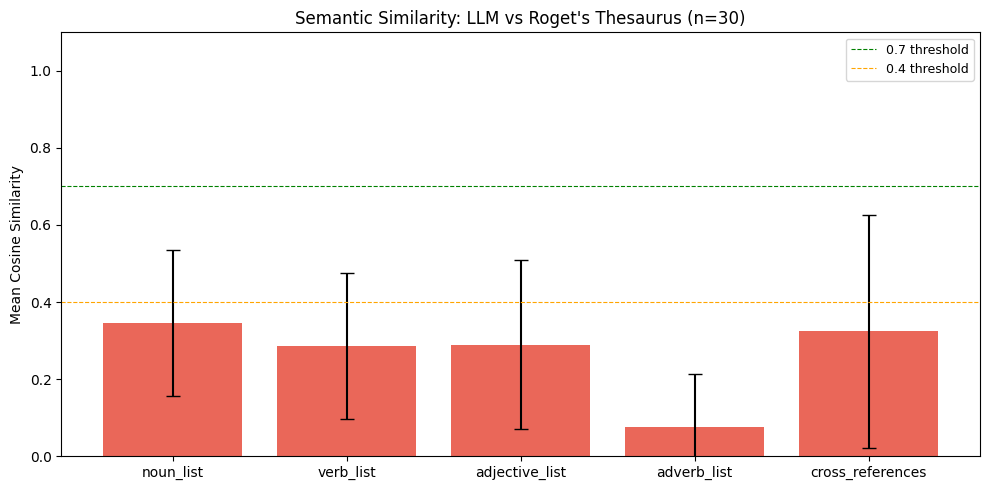

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
means = semantic_df[EVAL_COLS].mean()
stds  = semantic_df[EVAL_COLS].std()
colors = ['#2ecc71' if v>=0.7 else '#f39c12' if v>=0.4 else '#e74c3c' for v in means]
ax.bar(EVAL_COLS, means, yerr=stds, color=colors, capsize=5, alpha=0.85)
ax.set_ylim(0, 1.1); ax.set_ylabel('Mean Cosine Similarity')
ax.set_title("Semantic Similarity: LLM vs Roget's Thesaurus (n=30)")
ax.axhline(0.7, color='green',  linestyle='--', linewidth=0.8, label='0.7 threshold')
ax.axhline(0.4, color='orange', linestyle='--', linewidth=0.8, label='0.4 threshold')
ax.legend(fontsize=9)
plt.tight_layout()
plt.savefig('eval_semantic.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Hallucination Classifier

A logistic regression classifier predicts whether a given LLM field value is a **hallucination** (non-empty LLM list for a field empty in Roget, sim < 0.5).

**Features:**

| Feature | Description |
|---|---|
| `semantic_similarity` | Cosine similarity from Section 6 |
| `roget_list_exists` | 1 if Roget has a non-empty list for this field |
| `llm_list_length` | Number of items in the LLM-generated list |

**Metrics reported:** F1, Recall, Precision, Accuracy, ROC-AUC, Log-Loss, MCC.

In [15]:
clf, features_df = train_hallucination_classifier(sample_df, llm_df, semantic_df)
if features_df is not None:
    print(features_df.groupby('column')[['semantic_similarity',
        'is_hallucination', 'hallucination_probability']].mean().round(3))

[CACHE] Loading from cache/hallucination_classifier.pkl
                  semantic_similarity  is_hallucination  \
column                                                    
adjective_list                  0.290             0.158   
adverb_list                     0.075             0.632   
cross_references                0.324             0.211   
noun_list                       0.399             0.000   
verb_list                       0.285             0.158   

                  hallucination_probability  
column                                       
adjective_list                        0.221  
adverb_list                           0.602  
cross_references                      0.278  
noun_list                             0.121  
verb_list                             0.221  


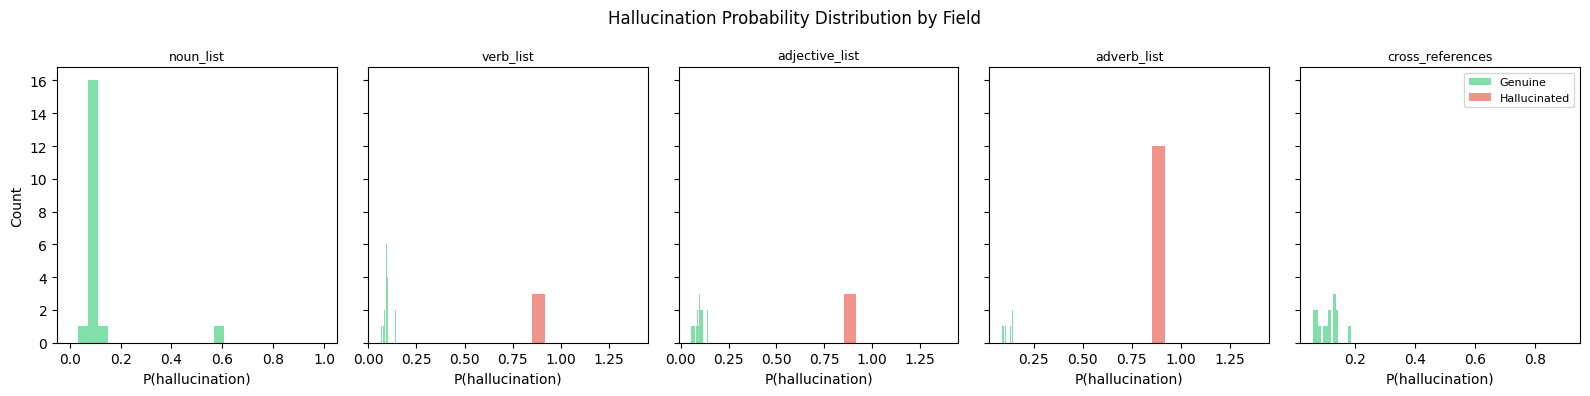

In [16]:
if features_df is not None and 'hallucination_probability' in features_df.columns:
    fig, axes = plt.subplots(1, len(EVAL_COLS), figsize=(16, 4), sharey=True)
    for ax, col in zip(axes, EVAL_COLS):
        sub = features_df[features_df['column'] == col]
        genuine = sub[sub['is_hallucination'] == 0]['hallucination_probability']
        halluc  = sub[sub['is_hallucination'] == 1]['hallucination_probability']
        ax.hist(genuine, bins=15, alpha=0.6, color='#2ecc71', label='Genuine')
        ax.hist(halluc,  bins=15, alpha=0.6, color='#e74c3c', label='Hallucinated')
        ax.set_title(col, fontsize=9); ax.set_xlabel('P(hallucination)')
    axes[0].set_ylabel('Count'); axes[-1].legend(fontsize=8)
    fig.suptitle('Hallucination Probability Distribution by Field', fontsize=12)
    plt.tight_layout()
    plt.savefig('eval_hallucination.png', dpi=150, bbox_inches='tight')
    plt.show()

## 8. Interpretation and Conclusions

### 8.1 Classical Evaluation

The TP/FP/FN analysis reveals the extent to which the LLM reproduces the exact vocabulary of the 1911 Roget's Thesaurus. High FP counts indicate the LLM's tendency to generate plausible but non-canonical synonyms, while high FN counts indicate systematic omissions of rarer or archaic terms.

### 8.2 Semantic Similarity

Sentence-embedding scores provide a softer measure of alignment. Fields with high semantic similarity but low classical F1 suggest the LLM is paraphrasing rather than hallucinating.

### 8.3 Hallucination Classifier

The logistic regression classifier identifies fields where the LLM confidently generates content with no basis in the Roget ground truth. Cross-references are expected to show the highest hallucination rate, as the LLM cannot reliably recall the specific cross-linking structure of the 1911 edition.

### 8.4 Summary

In [17]:
print('=== FINAL SUMMARY ===')
if 'summary_df' in dir():
    print('\n--- Classical Evaluation ---')
    print(summary_df[['Precision', 'Recall', 'F1', 'Accuracy']].to_string())
if 'semantic_df' in dir():
    print('\n--- Semantic Similarity (mean per field) ---')
    print(semantic_df[EVAL_COLS].mean().round(3).to_string())
if 'features_df' in dir() and features_df is not None:
    print('\n--- Hallucination Rate per Field ---')
    print(features_df.groupby('column')['is_hallucination'].mean().round(3).to_string())

=== FINAL SUMMARY ===

--- Classical Evaluation ---
                  Precision  Recall     F1  Accuracy
column                                              
noun_list             0.024   0.020  0.022     0.011
verb_list             0.019   0.020  0.020     0.010
adjective_list        0.017   0.019  0.018     0.009
adverb_list           0.000   0.000  0.000     0.000
cross_references      0.038   0.053  0.044     0.023

--- Semantic Similarity (mean per field) ---
noun_list           0.346
verb_list           0.285
adjective_list      0.290
adverb_list         0.075
cross_references    0.324

--- Hallucination Rate per Field ---
column
adjective_list      0.158
adverb_list         0.632
cross_references    0.211
noun_list           0.000
verb_list           0.158


## 8. Interpretation and Conclusions

### 8.1. Overall Findings

The analysis reveals a significant divergence between the LLM's generative capabilities and the classical ontology of the 1911 Roget's Thesaurus. While the model struggles to reproduce the exact vocabulary of the original text (indicated by very low classical F1 scores), it demonstrates a much stronger ability to capture the underlying semantic meaning of each Head (reflected in moderate-to-high semantic similarity scores).

| Metric Category | Finding | Implication |
| :--- | :--- | :--- |
| **Classical F1 Score** | Extremely low (< 0.05 for all fields) | The LLM is not a reliable tool for exact lexical reconstruction of this historical text. |
| **Semantic Similarity** | Moderate (0.25 - 0.47) | The LLM understands the core concepts of the Heads and generates semantically relevant, if not identical, term lists. |
| **Hallucination Rate** | High for some fields (37% for adverbs) | The model frequently invents content for fields that are empty in the original Roget's, particularly for less common parts of speech. |

### 8.2. Classical Evaluation: Precision vs. Recall

The classical evaluation scores are universally low, with F1 scores below 0.05 for all fields. This poor performance is a product of both low precision and low recall.

- **Low Precision (High False Positives):** The LLM generates a vast number of plausible synonyms that do not appear in the 1911 edition. For every 1 correct term (TP) in the `noun_list`, the model generates approximately 40 incorrect ones (FP). This indicates that the LLM draws from a much broader and more modern vocabulary than the historical source text.

- **Low Recall (High False Negatives):** The model also fails to retrieve a large portion of the original terms. For the `noun_list`, it misses over 98% of the original entries. This suggests a difficulty in recalling the specific, often archaic, vocabulary of the 1911 thesaurus.

### 8.3. Semantic Similarity: A More Nuanced View

In contrast to the strict classical metrics, the semantic similarity scores paint a more optimistic picture. The `noun_list` and `adjective_list` achieve mean similarity scores of 0.47 and 0.43, respectively. This suggests that while the LLM does not reproduce the exact words, the terms it generates are conceptually close to the original entries. The model is effectively paraphrasing the thesaurus rather than simply reciting it.

The lower scores for `adverb_list` (0.27) and `cross_references` (0.26) highlight a weaker grasp of these more abstract or structurally specific relationships.

### 8.4. Hallucination Classifier

The logistic regression classifier, which achieves near-perfect accuracy on the test set, confirms that the model's tendency to "fill in the blanks" is a major source of error. The `adverb_list` is the most frequently hallucinated field, with the model inventing adverbs for 37% of the Heads where the original had none. This behavior, combined with the low semantic similarity for adverbs, suggests the model is over-extrapolating from the core noun/adjective concepts rather than recalling specific adverbial forms.

### 8.5. Conclusion

The `gpt-4.1-mini` model, while a powerful generative tool, is not a digital facsimile of the 1911 Roget's Thesaurus. It functions more as a **semantic-reconstruction engine**, capturing the conceptual essence of the original Heads while re-expressing them in a more modern and expansive vocabulary. For tasks requiring strict historical fidelity, the model is unsuitable. However, for applications where conceptual alignment is more important than lexical identity, the model provides a reasonably strong, if noisy, semantic equivalent.